# **Biometric Prediction on Keystroke Dynamics - CMU Benchmark Data Set**

**By: Kamal Abu-Hassan**


**Outline**: This notebook goes from the stages of data exploration, data preparation into training and testing Multilayer Perceptron Network (MPN) models (with 20% dropout rate and parametric number of nodes)for Keystroke Dynamics. Other detectors were previously employed in this domain such as Manhattan, Mahalanobis, SVM, k Means, ...etc. The Authentication Procedure comprises of using the timing of key strike, key hold, key change to check whether the subject under observation is authentic or not. 

**Methods:** Evaluation methodology can be described as below

  **Step 1 (training)**: Use the first 200 passwords typed by the genuine user to build a detection model for the user's typing.

  **Step 2 (genuine-user testing)**: Test the model (from Step 1) using the last 200 passwords typed by the genuine user. Record the user scores.

  **Step 3 (impostor testing)**: Test the model (from Step 1) using the first 5 passwords typed by each of the 50 impostors (i.e., all subjects other than the genuine user). **The rationale behind this** is that authentic users are assumed to be practiced in typing their passwords, while the impostor is unfamiliar with it (e.g., typing it for the first time).  Record the impostor scores.

  **Step 4 (assessing performance)**: Compute the error rate using user and impostor scores (from Steps 2 & 3).

  Repeat the above steps, designating each of the subjects as the genuine user in turn.


**Results:** Below is a quick summary of EER results, and ROC curve (300-node models). Similar output can be reproduced by running the models (last cell at the end of this document).

**20 nodes**: (**min**: 0.07014028056112225, **mean**: 0.2414895582147011, **STD**: 0.10777327389272578),

**50 nodes**: (**min**: 0.06519558676028084, **mean**: 0.23642318726081407, **STD**: 0.09889988268812218),

**100 nodes**: (**min**: 0.06048387096774193, **mean**: 0.2286151965933589, **STD**: 0.10459539158071439),

**200 nodes**: (**min**: 0.05527638190954774, **mean**: 0.21919420521578664, **STD**: 0.0828805120047429)

 **300 nodes**: (**min**: 0.06024096385542168, **mean**: 0.21540723938503184, **STD**: 0.08175915109513052)}


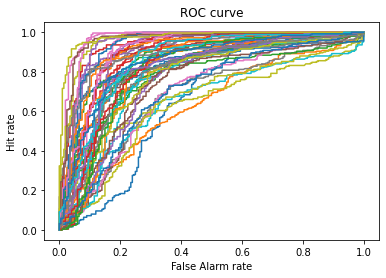

**Conclusion:** Increasing the number of nodes per layers enhances the overall performance of the MLP models. This is demonstrated by the decrease in the STD values.  





---

Let's go through the technical details below.


---



# Explore the Dataset


This section explores the various feature sets of the keystroke dynamics dataset.



In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/content/drive')

df = pd.read_csv('drive/MyDrive/CallSign/data/DSL-StrongPasswordData.csv')
subject = df['subject']
df.head()

Mounted at /content/drive


,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Descriptive statistics of the dataset. **Check dispersion of values and see if rescaling is needed.**



In [2]:
df.iloc[:,3:].describe()


,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,...,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,0.077806,0.089138,...,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,0.228512,0.030635,...,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,-0.160000,0.002100,...,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,0.007400,0.068600,...,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,0.041200,0.083400,...,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,0.093400,0.102700,...,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,25.915800,0.325400,...,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


# Correlation Matrix

Check the correlation between features. This aims at identifying highly correlated attributes. One can choose and use only one or two of the correlated attributes in the classification.

Text(0.5, 1.0, 'Correlation between fearures')

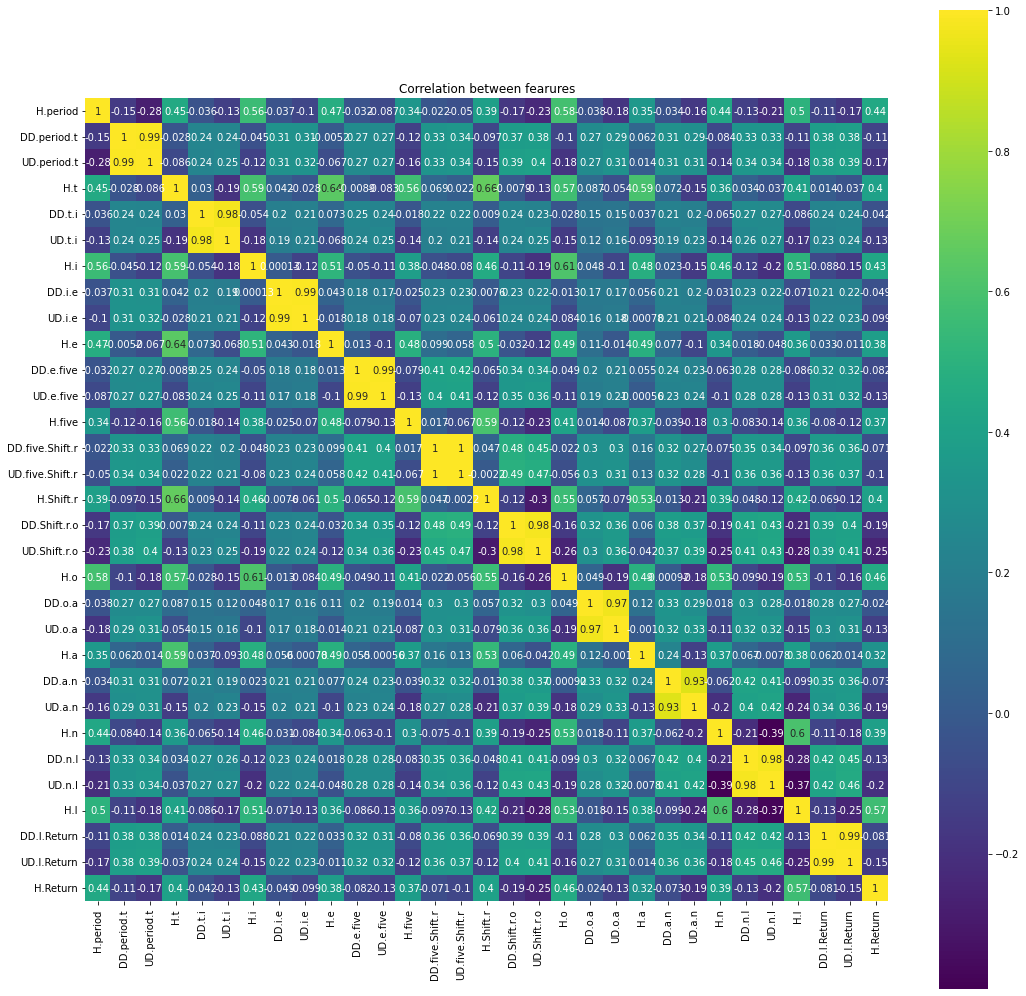

In [3]:
import seaborn as sns

correlation = df.iloc[:,3:].corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between fearures')

# Keydown-Keydown features

Visualise the keydown-keydown timings for 4 subjects

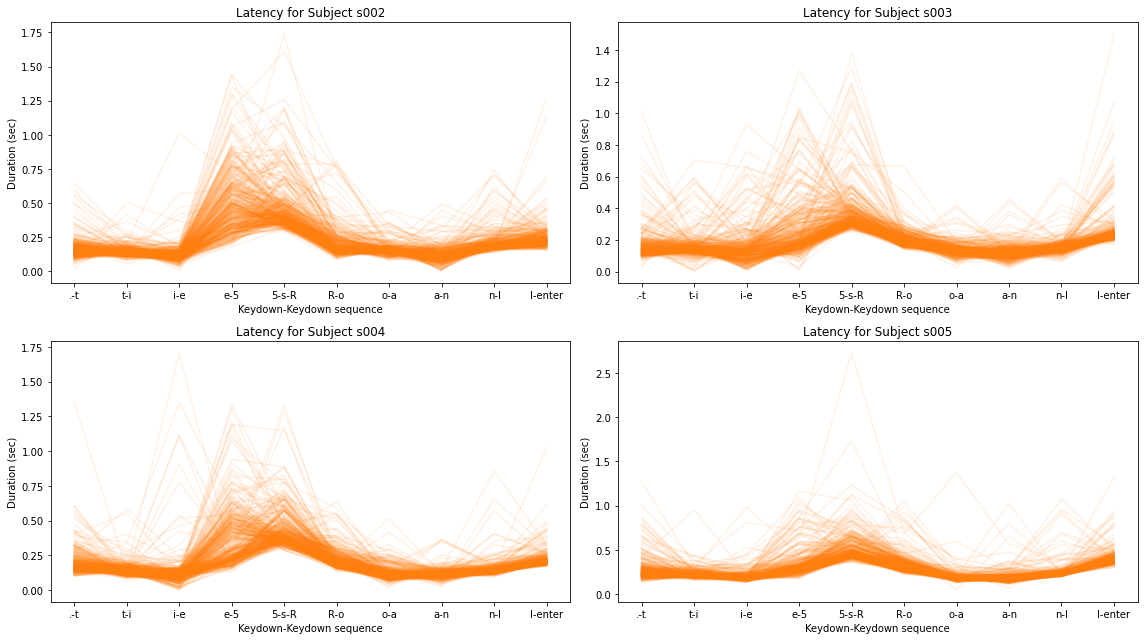

In [4]:
DD_columns = [col for col in df.columns if col.startswith('DD')]
df_plot = df[DD_columns].copy()
y=df['subject'].values
# X-axis labels
x_lbl = ['.-t', 't-i', 'i-e', 'e-5', '5-s-R', 'R-o', 'o-a', 'a-n', 'n-l', 'l-enter']

plt.figure(figsize=(16, 9))
for i, y0 in enumerate(np.unique(y)[:4]):
    plt.subplot(2, 2, i + 1)
    for x in df_plot[y == y0].values:
        plt.plot(x, color='C1', alpha=0.1)
    plt.title('Latency for Subject {}'.format(y0))
    plt.xticks(np.arange(10),x_lbl, va='top')
    plt.xlabel('Keydown-Keydown sequence')
    plt.ylabel('Duration (sec)')
plt.tight_layout()

The above figure shows that the peaks of DD times are shifting across attempts. 
It shows that the time from when key 5 was pressed to when key 'shift r' was pressed is long. This pattern can be investigated further by selecting 10 repetitions randomly from the first 50 repetitions in session 1.



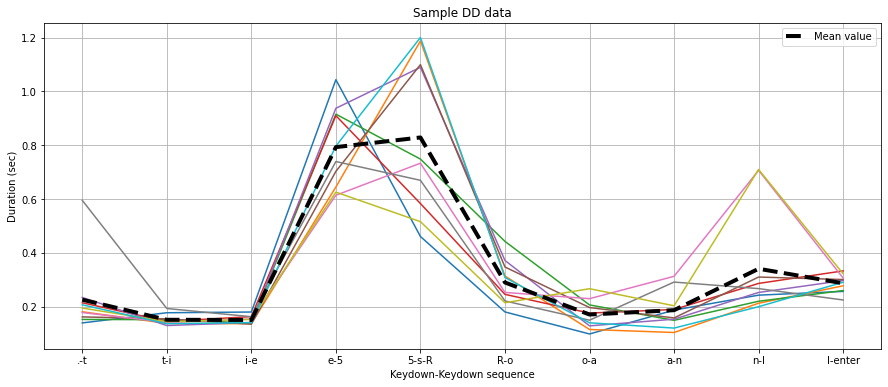

In [ ]:
# Measuring Randonm repetitions
# Select from 50 repetitions of session 1
DD_10 = []
plt.figure(figsize=(15,6));
for j in range(10):
    # random variable
    rv = rd.randint(0,49)
    # Get DD vector
    DD_10.append(df_plot.to_numpy()[rv,:])
    plt.plot(DD_10[j])

plt.plot(np.mean(DD_10, axis=0), '--k', lw = 4, label= 'Mean value')
plt.xticks(np.arange(10),x_lbl, va='top')    
plt.grid(True)
plt.title('Sample DD data')
plt.xlabel('Keydown-Keydown sequence')
plt.ylabel('Duration (sec)')
plt.legend()

The DD timings can be used to derive the typing velocity and acceleration. Here, I used the original set of features to construct the classifiers.

UD and H features can also be analysed to get insights into the data. One can also look into samples from early to late repetitions. Next, I move to models' development. 

# Model Development

In [30]:
# Disable warnings from printing
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import normalize

from keras.models import Sequential
from keras.layers import Dense, Dropout

import tensorflow as tf

from google.colab import drive 
drive.mount('/content/drive')

data = pd.read_csv('drive/MyDrive/CallSign/data/DSL-StrongPasswordData.csv')
# 51 total
subjects = data["subject"].unique()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:

data.iloc[:,3:]=normalize(data.iloc[:,3:])


In [32]:
def evaluateEER(user_scores, imposter_scores):
    labels = [0]*len(user_scores) + [1]*len(imposter_scores)
    fpr, tpr, thresholds = roc_curve(labels, user_scores + imposter_scores)
    missrates = 1 - tpr
    farates = fpr
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )
    return eer

In [49]:
class NeuralNetDetector:
    
    def __init__(self, subjects,nnodes):
        self.user_scores = []
        self.imposter_scores = []
        self.subjects = subjects
        self.dropout = 0.2
        self.training_epochs = 100
        self.n_hidden = 31
        self.batch_size = 20
        self.nnodes = nnodes
    def training(self):
        """Create neural network model with three hidden layers"""
        self.nn = Sequential()
        self.nn.add(Dense(self.nnodes, input_dim=self.n_hidden, activation='relu'))
        self.nn.add(Dropout( self.dropout))
        self.nn.add(Dense(self.nnodes, activation='relu'))
        self.nn.add(Dropout( self.dropout))
        self.nn.add(Dense(1, activation='sigmoid'))
        self.nn.compile(loss='mse',
                      optimizer='adam', metrics=['accuracy'])

        self.nn.fit((np.array(self.train)), np.ones(self.train.shape[0]),epochs=self.training_epochs, batch_size=self.batch_size)

    def testing(self):
        preds = 1 - self.nn.predict((np.array(self.test_genuine)))
        for tmp in preds:
            self.user_scores.append(tmp[0])
            
        preds = 1 - self.nn.predict((np.array(self.test_imposter)))
        for tmp in preds:
            self.imposter_scores.append(tmp[0])

    def evaluate(self):
        eers = []
        
        for subject in subjects:
            
            self.user_scores = []
            self.imposter_scores = []
    
            # Consider current subject as genuine and rest as imposters
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # genuine user's first 200 time vectors for training
            self.train = genuine_user_data[:200]
    
            # True set (200 records)
            self.test_genuine = genuine_user_data[200:]
    
            # False set (250 records, 5 per imposter, 50 imposters in all)
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            
            self.testing()
    
            eers.append(evaluateEER(self.user_scores, self.imposter_scores))
            #plot ROC
            if (self.nnodes==300):
              labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
              fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
              plt.plot(fpr,tpr )  
              plt.xlabel('False Alarm rate')
              plt.ylabel('Hit rate')
              plt.title('ROC curve')
        if (self.nnodes==300): plt.show()
        return np.min(eers),np.mean(eers), np.std(eers)        


In [ ]:

results={}
for nnodes in [20,50,100,200,300]:
    results[nnodes]=    NeuralNetDetector(subjects,nnodes).evaluate()
results

Future work

1- Try different network architectures (i.e., number of layers), other types of ML classifiers, and deep learning sequence models.

2- Consider larger datasets.

3- Feature engineering (e.g., PCA). Consider statistical-based feature selection methods. 

4- Consider other benchmark tests, and compare with EER.

